In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import scipy
from scipy.stats import kde
from scipy.stats.distributions import gamma, lognorm
from math import sqrt


from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy import stats

In [2]:
# Расчет доверительных интервалов для 25%, 50% и 75% квантилей
def conf_intervals(data, qn):
    # 95% квантиль распределения Гаусса
    norm_q95 = scipy.stats.norm.ppf(0.95)
    kernel = scipy.stats.gaussian_kde(data)

    p25 = len(data[data < qn[5]]) / len(data)
    sigma25 = \
        (sqrt((p25 * (1 - p25)) / len(data))) / kernel(qn[5])
    p50 = len(data[data < qn[10]]) / len(data)
    sigma50 = \
        (sqrt((p50 * (1 - p50)) / len(data))) / kernel(qn[10])
    p75 = len(data[data < qn[15]]) / len(data)
    sigma75 = \
        (sqrt((p75 * (1 - p75)) / len(data))) / kernel(qn[15])

    conf_q25 = norm_q95 * sigma25
    conf_q50 = norm_q95 * sigma50
    conf_q75 = norm_q95 * sigma75

    return [conf_q25, conf_q50, conf_q75]

## Загрузка и предобработка датасета

In [3]:
df = pd.read_csv("point_255_70_67_73_97_1989-01-01_00_2015-12-31_23.txt", skiprows = 5, header = None, sep="\s+")
df.drop([13, 14, 15, 16], axis=1, inplace=True)
df.head()

0   1    2    3   4    5    6    7    8    9    10   11   12    17
0  19890101   0  5.0  312  54  9.0  313  8.1  306  6.2  287  5.3  252  0.99
1  19890101   1  4.7  316  46  6.8  325  7.4  329  4.6  318  2.2  261  1.00
2  19890101   2  4.5  315  41  5.0  347  6.8    2  4.0   18  2.2   94  1.00
3  19890101   3  4.2  316  43  5.1   19  8.0   40  7.0   64  7.1   98  1.00
4  19890101   4  4.3  321  43  5.1   19  8.0   40  7.0   64  7.1   98  1.00

In [4]:
descr = ''
with open('description.txt', encoding='utf-8') as f:
    descr = f.readlines()
descr = "".join(descr[-2:])  
# .split('> <', '> \n<')
re.split('> <|> \n<|. <', descr)

['<Дата в форме ГГГГММДД:8:0',
 'Время в форме ЧЧ:2:0',
 'Модуль скорости ветра, м/ c :4:1',
 'Направление ветра , o :3:0',
 'Уровень, см, 3:0',
 'Модуль скорости течений на поверхностном горизонте, см/ c :5:1',
 'Направление течений на поверхностном горизонте , o , 0>............ (все горизонты от поверхности - до дна) ...........',
 'Модуль скорости течений на придонном горизонте, см/ c :5:1',
 'Направление  течений на придонном горизонте , o , 0',
 'Значительные высоты волн, м, 4:1',
 'Периоды пика волн, с, 5:2',
 'Средние периоды волн, с, 5:2',
 'Направления волн , o ,3:0',
 'Концентрация льда:4:2>']

In [5]:
df.columns = ["date", "hour", "wind_speed", "wind_direction", "level", 
                "flow_speed", "flow_direction", "flow_speed_nh", 
                "flow_direction_nh", "wave_heights", "wawes_peak_periods",
                "mean_wawes_periods", "waves_direction", "ice_conc"]

### Итоговый датасет

In [6]:
df['date'] = pd.to_datetime(df['date'].apply(str) + df['hour'].apply(str), format='%Y%m%d%H')
df.drop(['hour'], axis=1, inplace=True)
df.head()

date  wind_speed  wind_direction  level  flow_speed  \
0 1989-01-01 00:00:00         5.0             312     54         9.0   
1 1989-01-01 01:00:00         4.7             316     46         6.8   
2 1989-01-01 02:00:00         4.5             315     41         5.0   
3 1989-01-01 03:00:00         4.2             316     43         5.1   
4 1989-01-01 04:00:00         4.3             321     43         5.1   

   flow_direction  flow_speed_nh  flow_direction_nh  wave_heights  \
0             313            8.1                306           6.2   
1             325            7.4                329           4.6   
2             347            6.8                  2           4.0   
3              19            8.0                 40           7.0   
4              19            8.0                 40           7.0   

   wawes_peak_periods  mean_wawes_periods  waves_direction  ice_conc  
0                 287                 5.3              252      0.99  
1                 318                 2.2              261      1.00  
2                  18                 2.2               94      1.00  
3                  64                 7.1               98      1.00  
4                  64                 7.1               98      1.00

## Строим корреляционную матрицу для выбора переменных

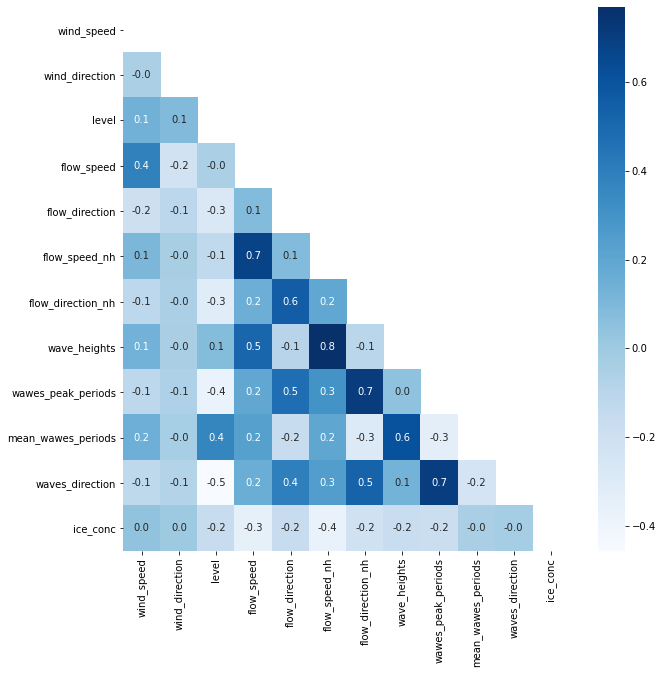

In [7]:
#отбор столбцов для построения коррекляционной матрицы
X_train = df[df.columns[1:]]

#построение диагональной маски
mask = np.zeros_like(X_train.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(X_train.corr(), mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

In [8]:
choosen_varibales = ['wave_heights', 'flow_speed_nh'] # Выбранные переменныеи

# Задание 1

### Переменная 1

выборочное среднее 5.6018541053983695
выборочная медиана 4.9
выборочная дисперсия 11.81918925399292
выборочное СКО 3.4379047767489026
выборочная мода 3.5


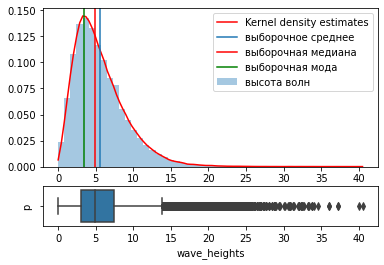

In [9]:
data = df[choosen_varibales[0]]
mean = np.average(data)
median = np.median(data)
var = data.var()
std = data.std()
lst = list(data)
mode = max(set(lst), key=lst.count)

print('выборочное среднее', mean)
print('выборочная медиана', median)
print('выборочная дисперсия', var)
print('выборочное СКО', std)
print('выборочная мода', mode)

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
sns.distplot(data, kde=False, norm_hist=True, label = 'высота волн', ax = ax1)
density = kde.gaussian_kde(data)
xgrid = np.linspace(data.min(), data.max(), 100)
y = density(xgrid)
ax1.plot(xgrid, y, 'r-', label = 'Kernel density estimates')
plt.ylabel('p', axes=ax1)
ax1.axvline(x=mean, label='выборочное среднее')
ax1.axvline(x=median, label='выборочная медиана', color='r')
ax1.axvline(x=mode, label='выборочная мода', color='g')
ax1.legend()
sns.boxplot(x=data, ax = ax2)

In [10]:
# Расчет 95% доверительного интервала для выборочного среднего
norm_q95 = scipy.stats.norm.ppf(0.95)
mean_conf = norm_q95 * std / np.sqrt(len(data))

# Расчет 95% доверительных интервалов для дисперсии и СКО
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(data) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(data) - 1)

var_conf_left = var * (len(data) - 1) / chi2_q95_left
var_conf_right = var * (len(data) - 1) / chi2_q95_right
std_conf_left = np.sqrt(var_conf_left)
std_conf_right = np.sqrt(var_conf_right)

# Вывод полученных значений в консоль
print("Выборочное среднее: %0.3f +/- %0.3f" % (mean, mean_conf))
print("95%% Доверительный интервал выборочной дисперсии : (%0.3f; %0.3f)"
      % (var_conf_left, var_conf_right))
print("95%% Доверительный интервал выборочного СКО: (%0.3f; %0.3f)"
      % (std_conf_left, std_conf_right))

Выборочное среднее: 5.602 +/- 0.012
95% Доверительный интервал выборочной дисперсии : (11.752; 11.887)
95% Доверительный интервал выборочного СКО: (3.428; 3.448)


In [11]:
# Расчет квантилей
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(data, percs)

conf_first = conf_intervals(data, qn_first)
conf_first = [round(i[0], 4) for i in conf_first ]

print(f'25%, 50%, 75% - доверительные интервалы для wave_heights:\n {conf_first}')

25%, 50%, 75% - доверительные интервалы для wave_heights:
 [0.0101, 0.0134, 0.0192]


3х параметрическое гаммма распределение методом максимального правдоподобия (2.827, -0.132, 2.028)


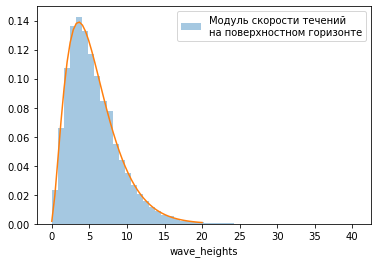

In [12]:
gamma_params = gamma.fit(data)
print('3х параметрическое гаммма распределение методом максимального правдоподобия (%0.3f, %0.3f, %0.3f)' % gamma_params)
sns.distplot(data, kde=False, norm_hist=True, label = 'Модуль скорости течений \nна поверхностном горизонте')
plt.plot(np.linspace(0, 20), gamma.pdf(np.linspace(0, 20), *gamma_params))
plt.legend()

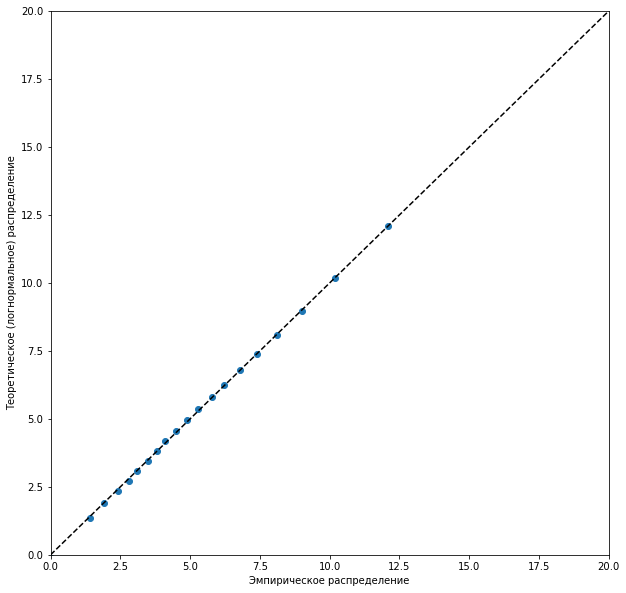

In [13]:
x = np.linspace(np.min(data), np.max(data))

# Параметры распределения определяются при помощи функции fit на основе метода максимального правдоподобия 
pdf = scipy.stats.gamma.pdf(x, *gamma_params)

percs = np.linspace(0, 100, 21)
qn_first = np.percentile(data, percs)
qn_gamma = scipy.stats.gamma.ppf(percs / 100.0, *gamma_params)

# Построение квантильного биплота
plt.figure(figsize=(10, 10))
plt.plot(qn_first, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel(f'Эмпирическое распределение')
plt.ylabel('Теоретическое (логнормальное) распределение')

plt.show()

In [14]:
ks = scipy.stats.kstest(data, 'gamma', gamma_params, N=100)
chi2 = scipy.stats.chisquare(data)
print('Критерий Колмагорова', ks)
print('хи-квадрат', chi2)

Критерий Колмагорова KstestResult(statistic=0.012151287281772116, pvalue=8.795906773426411e-31)
хи-квадрат Power_divergenceResult(statistic=499328.3890994218, pvalue=0.0)


### Переменная 2

выборочное среднее 7.446163337051686
выборочная медиана 6.6
выборочная дисперсия 18.898797768600225
выборочное СКО 4.347274751910699
выборочная мода 5.5


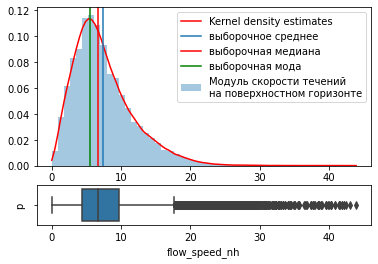

In [15]:
data = df[choosen_varibales[1]]
mean = np.average(data)
median = np.median(data)
var = data.var()
std = data.std()
lst = list(data)
mode = max(set(lst), key=lst.count)

print('выборочное среднее', mean)
print('выборочная медиана', median)
print('выборочная дисперсия', var)
print('выборочное СКО', std)
print('выборочная мода', mode)

f, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]})
sns.distplot(data, kde=False, norm_hist=True, label = 'Модуль скорости течений \nна поверхностном горизонте', ax = ax1)
density = kde.gaussian_kde(data)
xgrid = np.linspace(data.min(), data.max(), 100)
y = density(xgrid)
ax1.plot(xgrid, y, 'r-', label = 'Kernel density estimates')
plt.ylabel('p', axes=ax1)
ax1.axvline(x=mean, label='выборочное среднее')
ax1.axvline(x=median, label='выборочная медиана', color='r')
ax1.axvline(x=mode, label='выборочная мода', color='g')
ax1.legend()
sns.boxplot(x=data, ax = ax2)

In [16]:
# Расчет 95% доверительного интервала для выборочного среднего
norm_q95 = scipy.stats.norm.ppf(0.95)
mean_conf = norm_q95 * std / np.sqrt(len(data))

# Расчет 95% доверительных интервалов для дисперсии и СКО
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(data) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(data) - 1)

var_conf_left = var * (len(data) - 1) / chi2_q95_left
var_conf_right = var * (len(data) - 1) / chi2_q95_right
std_conf_left = np.sqrt(var_conf_left)
std_conf_right = np.sqrt(var_conf_right)

# Вывод полученных значений в консоль
print("Выборочное среднее: %0.3f +/- %0.3f" % (mean, mean_conf))
print("95%% Доверительный интервал выборочной дисперсии : (%0.3f; %0.3f)"
      % (var_conf_left, var_conf_right))
print("95%% Доверительный интервал выборочного СКО: (%0.3f; %0.3f)"
      % (std_conf_left, std_conf_right))

Выборочное среднее: 7.446 +/- 0.015
95% Доверительный интервал выборочной дисперсии : (18.792; 19.007)
95% Доверительный интервал выборочного СКО: (4.335; 4.360)


In [17]:
# Расчет квантилей
percs = np.linspace(0, 100, 21)
qn_second = np.percentile(data, percs)

conf_second = conf_intervals(data, qn_second)
conf_second = [round(i[0], 4) for i in conf_second ]

print(f'25%, 50%, 75% - доверительные интервалы для flow_speed_nh:\n {conf_second}')

25%, 50%, 75% - доверительные интервалы для flow_speed_nh:
 [0.0138, 0.0161, 0.0251]


3х параметрическое гаммма распределение методом максимального правдоподобия (3.233, -0.341, 2.408)


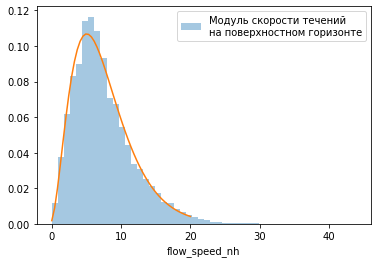

In [18]:
gamma_params = gamma.fit(data)
print('3х параметрическое гаммма распределение методом максимального правдоподобия (%0.3f, %0.3f, %0.3f)' % gamma_params)
sns.distplot(data, kde=False, norm_hist=True, label = 'Модуль скорости течений \nна поверхностном горизонте')
plt.plot(np.linspace(0, 20), gamma.pdf(np.linspace(0, 20), *gamma_params))
plt.legend()

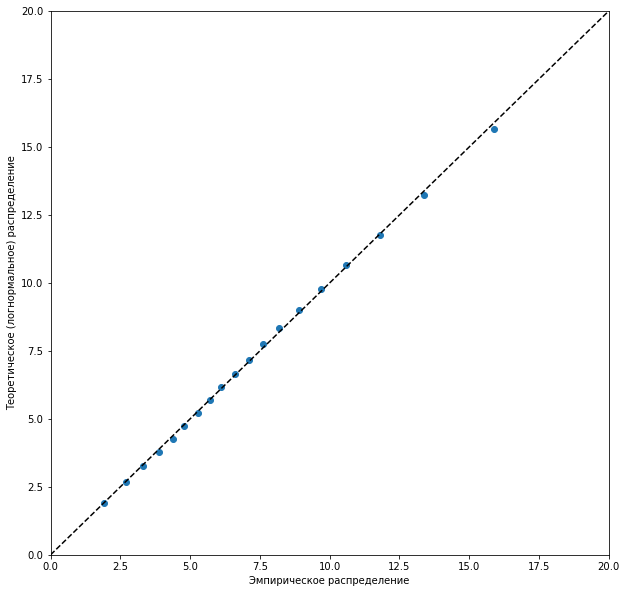

In [19]:
x = np.linspace(np.min(data), np.max(data))

# Параметры распределения определяются при помощи функции fit на основе метода максимального правдоподобия 
pdf = scipy.stats.lognorm.pdf(x, *gamma_params)

percs = np.linspace(0, 100, 21)
qn_second = np.percentile(data, percs)
qn_gamma = scipy.stats.gamma.ppf(percs / 100.0, *gamma_params)

# Построение квантильного биплота
plt.figure(figsize=(10, 10))
plt.plot(qn_second, qn_gamma, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel(f'Эмпирическое распределение')
plt.ylabel('Теоретическое (логнормальное) распределение')

plt.show()

In [20]:
ks = scipy.stats.kstest(data, 'gamma', gamma_params, N=100)
chi2 = scipy.stats.chisquare(data)
print('Критерий Колмагорова', ks)
print('хи-квадрат', chi2)

Критерий Колмагорова KstestResult(statistic=0.015243753128884263, pvalue=3.3646127754297456e-48)
хи-квадрат Power_divergenceResult(statistic=600664.5266636054, pvalue=0.0)


## Построение квантильного биплота для двух случайных величин

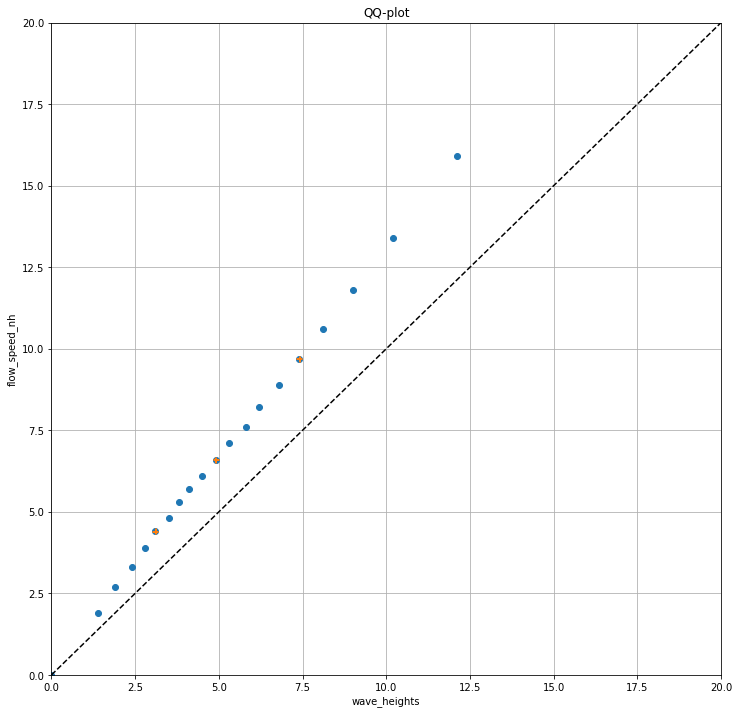

In [21]:
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlabel('wave_heights')
plt.ylabel('flow_speed_nh')
plt.xlim([min_qn, 20])
plt.ylim([min_qn, 20])
plt.grid(True)

# Добавление доверительных интервалов на график
plt.errorbar(
    # [25%, 50%, 75%]
    [qn_first[5], qn_first[10], qn_first[15]],
    [qn_second[5], qn_second[10], qn_second[15]],
    xerr=conf_first,
    yerr=conf_second,
    ls='none',
    capsize=3,
    elinewidth=2
)

plt.title('QQ-plot')
plt.show()

# Задание 2

### Гистограммы МСВ

<ipython-input-22-8b69c5e0cc03>:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


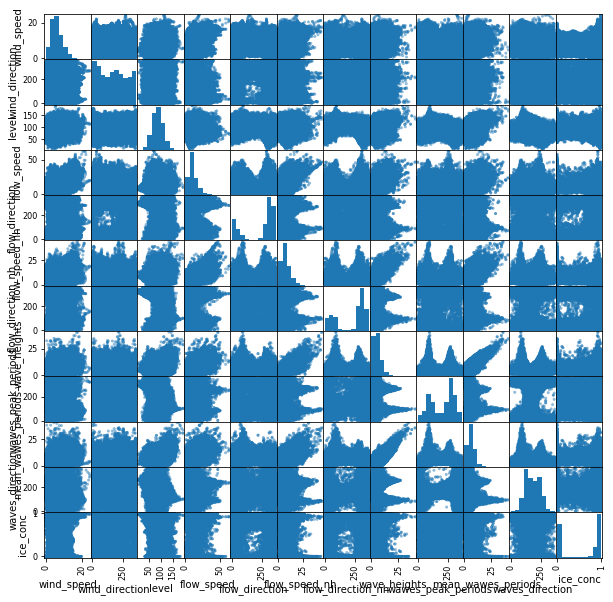

In [22]:
pd.plotting.scatter_matrix(df[df.columns[1:]], diagonal="hist", figsize = (10, 10))
plt.tight_layout()
plt.show()

### Ядерные оценки плотности распределения МСВ

<ipython-input-23-0654df458e6c>:2: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


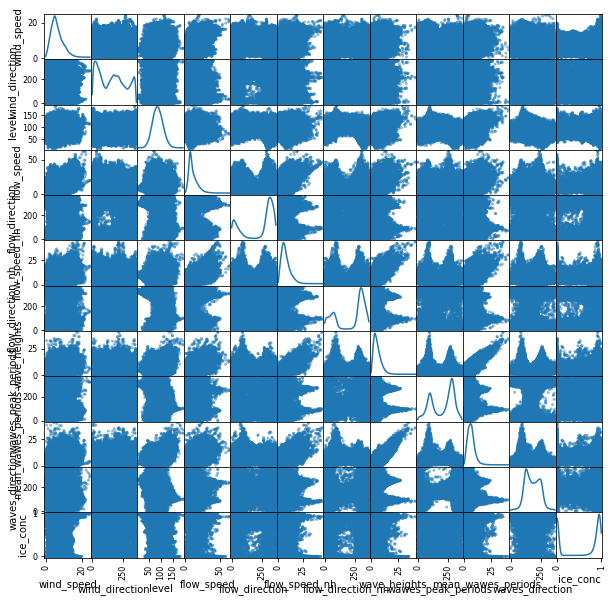

In [23]:
pd.plotting.scatter_matrix(df[df.columns[1:]], diagonal="kde", figsize = (10, 10))
plt.tight_layout()
plt.show()

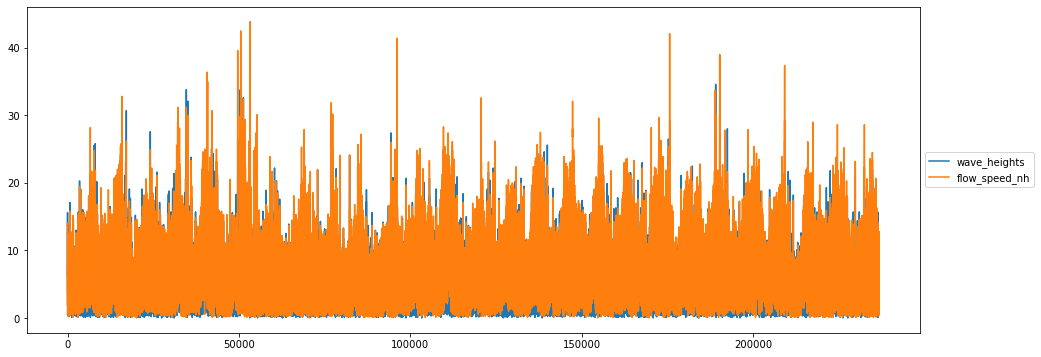

In [24]:
ax = df[['wave_heights', 'flow_speed_nh']].plot(figsize= (16,6))
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [9]:
X = df[['wave_heights', 'flow_speed_nh']]

In [10]:
std=X.apply(np.std)
var=X.apply(np.var)
print("Математическое ожидание МСВ:\n", std)
print("Дисперсия МСВ:\n", var)

Математическое ожидание МСВ:
 wave_heights     3.437898
flow_speed_nh    4.347266
dtype: float64
Дисперсия МСВ:
 wave_heights     11.819139
flow_speed_nh    18.898718
dtype: float64


In [11]:
X = df[df.columns[1:]]
standardisedX = scale(X)
standardisedX = pd.DataFrame(standardisedX, index=X.index, columns=X.columns)
pca = PCA().fit(standardisedX)
def screeplot(pca, standardised_values):
    y = np.std(pca.transform(standardised_values), axis=0)**2
    x = np.arange(len(y)) + 1
    plt.plot(x, y, "o-")
    plt.xticks(x, ["Comp."+str(i) for i in x], rotation=60)
    plt.ylabel("Variance")
    plt.show()

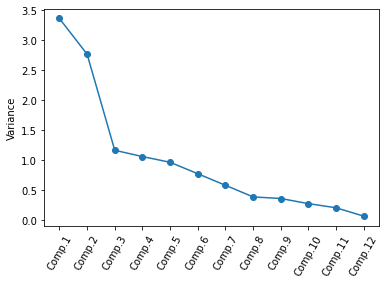

In [12]:
screeplot(pca, standardisedX)

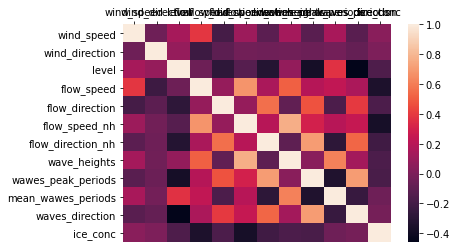

In [13]:
corrmat = X.corr()
sns.heatmap(corrmat, vmax=1., square=False).xaxis.tick_top()

In [16]:
#Доверительный интервал для коэффициента корреляции
x = X.wave_heights
y =  X.flow_speed_nh
r, p = stats.pearsonr(x,y)

# Расчет 95% доверительных интервалов для дисперсии и СКО
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(data) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(data) - 1)

r_conf_left = r * (len(x) - 1) / chi2_q95_left
r_conf_right = r * (len(x) - 1) / chi2_q95_right

print('Коэффициент корреляции  для wave_heights и flow_speed_nh = %0.3f' % r)
print('Доверительный интервал для коэффициента корреляции (%0.3f; %0.3f)'% (r_conf_left, r_conf_right))

Коэффициент корреляции  для wave_heights и flow_speed_nh = 0.769
Доверительный интервал для коэффициента корреляции (0.765; 0.774)


In [17]:
#Доверительный интервал для коэффициента корреляции
x = X.wave_heights
y =  X.flow_speed
r, p = stats.pearsonr(x,y)

# Расчет 95% доверительных интервалов для дисперсии и СКО
chi2_q95_left = scipy.stats.chi2.ppf((1 - 0.05 / 2.0), df=len(data) - 1)
chi2_q95_right = scipy.stats.chi2.ppf(0.05 / 2.0, df=len(data) - 1)

r_conf_left = r * (len(x) - 1) / chi2_q95_left
r_conf_right = r * (len(x) - 1) / chi2_q95_right

print('Коэффициент корреляции  для wave_heights и flow_speed = %0.3f' % r)
print('Доверительный интервал для коэффициента корреляции (%0.3f; %0.3f)'% (r_conf_left, r_conf_right))

Коэффициент корреляции  для wave_heights и flow_speed = 0.514
Доверительный интервал для коэффициента корреляции (0.511; 0.517)


In [18]:
print(stats.spearmanr(X.wave_heights, X.flow_speed_nh))

SpearmanrResult(correlation=0.6916275951052777, pvalue=0.0)


In [19]:
print(stats.spearmanr(X.wave_heights, X.flow_speed))

SpearmanrResult(correlation=0.42638305865099146, pvalue=0.0)


In [24]:
corr = stats.pearsonr(X.wave_heights, X.flow_speed)
print('corr =', corr[0])
print('p =', corr[1])

corr = 0.5137726240535523
p = 0.0


In [26]:
a = X.corr()

In [27]:
a.to_csv('table.csv')

In [28]:
from sklearn.metrics import r2_score

### Задача регрессии

In [34]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import math
import pylab 
from sklearn.linear_model import  LassoLarsIC

In [35]:
df.columns

Index(['date', 'wind_speed', 'wind_direction', 'level', 'flow_speed',
       'flow_direction', 'flow_speed_nh', 'flow_direction_nh', 'wave_heights',
       'wawes_peak_periods', 'mean_wawes_periods', 'waves_direction',
       'ice_conc'],
      dtype='object')

In [36]:
#Выделяем предикторы
X = df[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'waves_direction']]
#Выделяем целевую переменную
y = df[['wave_heights']]
#Деление на тренировочную и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

x = []
for i in range(len(y_test)):
    x.append(i)
#Создание модели линейной регрессии
reg = LinearRegression(normalize=True)
#Обучение модели линейной регрессии
reg.fit(X_train, y_train)
#Прогноз на тестовой выборке
y_pred = reg.predict(X_test)
params = np.append(reg.intercept_,reg.coef_)

In [37]:
#Вычисление метрик регрессии
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)

Mean absolute error =  1.0420909889424064
Mean squared error =  2.0035661674267233


In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape)

Mean absolute percentage error =  wave_heights    inf
dtype: float64


In [39]:
#Регуляризация лассо
clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train, y_train)
print(clf.coef_)

[-0.0505808   0.55172866  0.53366759  0.00550097]


In [40]:
model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X_train, y_train)
alpha_aic_ = model_aic.coef_
alpha_aic_

C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([-0.06111625,  0.56523955,  0.54438327,  0.00560249])

In [41]:
y_pred_lasso = clf.predict(X_test)
y_pred_lasso_aic = model_aic.predict(X_test)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
mae_lasso_aic = mean_absolute_error(y_test, y_pred_lasso_aic)
print('Mean absolute error with lasso = ', mae_lasso)
print('Mean squared error with lasso = ', mse_lasso)
print('Mean absolute error with aic lasso = ', mae_lasso_aic)

Mean absolute error with lasso =  1.0475439823330563
Mean squared error with lasso =  2.008417322729248
Mean absolute error with aic lasso =  1.0420909889424064


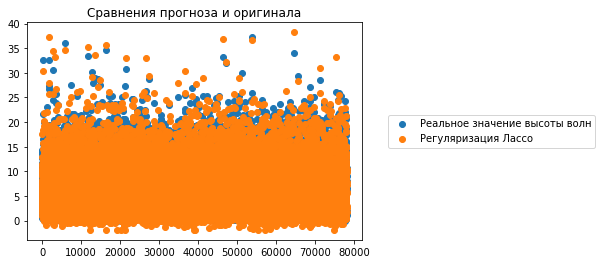

In [42]:
#График реальных и предсказанных значений
plt.scatter(x, y_test, label = u'Реальное значение высоты волн')
plt.scatter(x, y_pred, label = u'Регуляризация Лассо')
plt.title(u'Сравнения прогноза и оригинала')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))

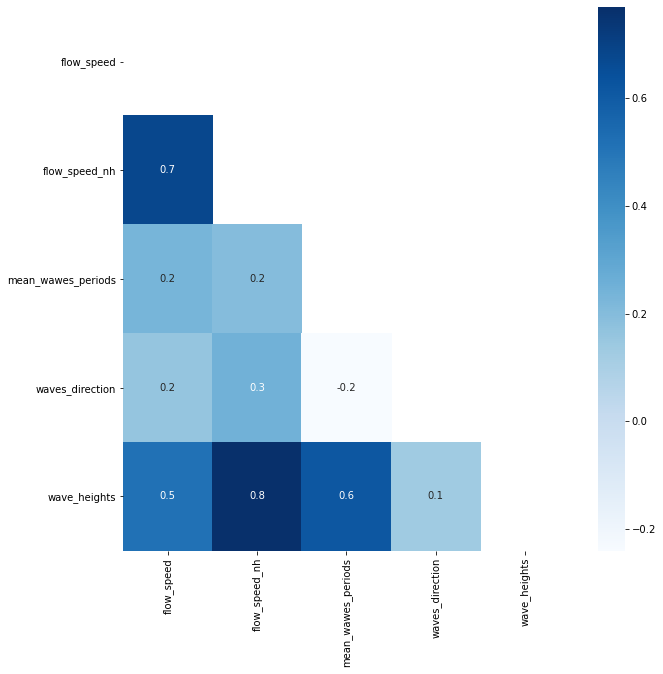

In [43]:
#Построение корреляционной матрицы признаков
dataset = df[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'waves_direction', 'wave_heights']]
corr = dataset.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(10, 10))

sns.heatmap(corr, mask = mask, annot=True, fmt= '.1f', ax = ax, cmap = 'Blues')

In [44]:
#Отбор трёх самых значимых признаков
X = df[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods']]
#Нормирование признаков
scaler = StandardScaler()
y = df[['wave_heights']]
X = pd.DataFrame(scaler.fit_transform(X))
X.columns = ['flow_speed', 'flow_speed_nh', 'mean_wawes_periods']
scaler = StandardScaler()
y = pd.DataFrame(scaler.fit_transform(y))
y.columns = ['wave_heights']
#Деление на тестовую и тренировочную выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
#Создание и обучение модели линейной регрессии
reg = LinearRegression(normalize=True)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
y_pred_all = np.array(reg.predict(X))


In [45]:
#Вычисление метрик модели
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print('Mean absolute error = ', mae)
print('Mean squared error = ', mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
print('Mean absolute percentage error = ', mape)

Mean absolute error =  0.3102144784903429
Mean squared error =  0.17751356888814923
Mean absolute percentage error =  wave_heights    574.804893
dtype: float64


In [46]:
mape = mean_absolute_percentage_error(y_test[:20000], y_pred[:20000])
print('Mean absolute percentage error = ', mape)

Mean absolute percentage error =  wave_heights    547.869026
dtype: float64


Text(0, 0.5, 'Предсказанные значения')

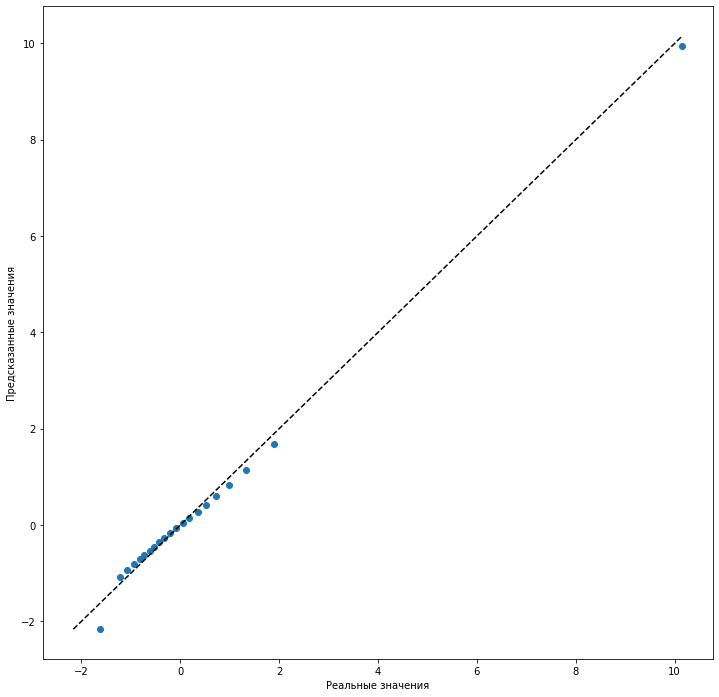

In [47]:
#Построение квантильного биплота по реальным и предсказанным значениям
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y, percs)
qn_second = np.percentile(y_pred_all, percs)
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Реальные значения')
plt.ylabel(u'Предсказанные значения')

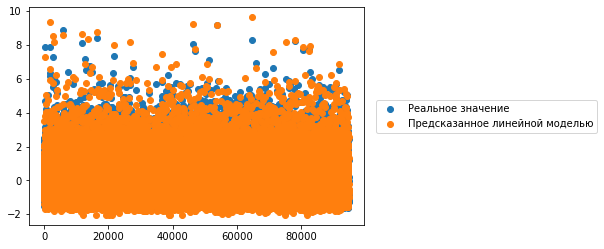

In [48]:
x = []

for i in range(len(y_test)):
    x.append(i)
#График реальных и предсказанных значений
plt.scatter(x, y_test, label = u'Реальное значение')
plt.scatter(x, y_pred, label = u'Предсказанное линейной моделью')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.7, 0.5))

In [49]:
#Построение и обучение полиномиальной регрессии 2-й степени
poly = PolynomialFeatures(2)
X_train_new = poly.fit_transform(X_train)
poly = PolynomialFeatures(2)
X_test_new = poly.fit_transform(X_test)
reg = LinearRegression(normalize=True)
reg.fit(X_train_new, y_train)
y_pred_poly = reg.predict(X_test_new)
X_new = poly.fit_transform(X)
y_pred_poly_all = reg.predict(X_new)

Text(0, 0.5, 'Предсказанные значения')

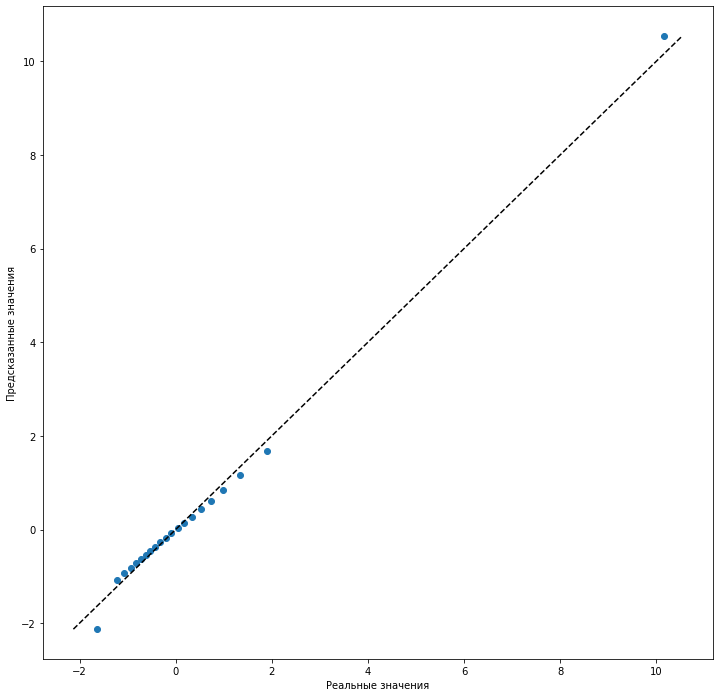

In [50]:
#Построение квантильного биплота по реальным и предсказанным значениям
percs = np.linspace(0, 100, 21)
qn_first = np.percentile(y, percs)
qn_second = np.percentile(y_pred_poly_all , percs)
plt.figure(figsize=(12, 12))

min_qn = np.min([qn_first.min(), qn_second.min()])
max_qn = np.max([qn_first.max(), qn_second.max()])
x = np.linspace(min_qn, max_qn)

plt.plot(qn_first, qn_second, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")

plt.xlabel(u'Реальные значения')
plt.ylabel(u'Предсказанные значения')

In [51]:
#Вычисление метрик модели
mae_poly = mean_absolute_error(y_test, y_pred_poly)
mse_poly = mean_squared_error(y_test, y_pred_poly)
print('Mean absolute error with Polynomial model = ', mae_poly)
print('Mean squared error with Polynomial model = ', mse_poly)

Mean absolute error with Polynomial model =  0.3009131474717894
Mean squared error with Polynomial model =  0.16578593780497106


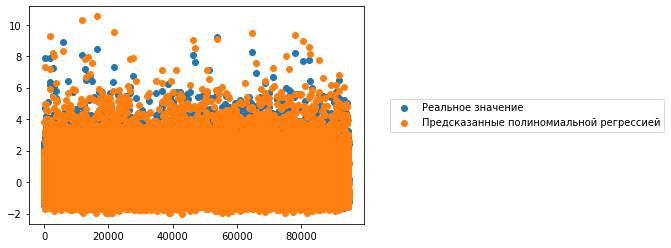

In [52]:
x = []
#Визуализация реальных и предсказанных значений
for i in range(len(y_test)):
    x.append(i)
plt.scatter(x, y_test, label = u'Реальное значение')
plt.scatter(x, y_pred_poly, label = u'Предсказанные полиномиальной регрессией')
plt.legend(loc="center right",borderaxespad=0.1, bbox_to_anchor=(1.9, 0.5))

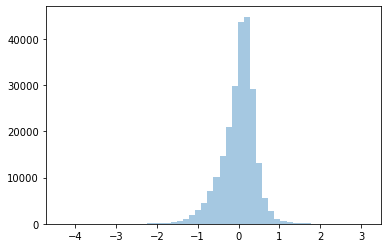

In [53]:
#Построение распределения остатков
y1 = np.array(y)
y2 = np.array(y_pred_all)
y_diff = y1[:,0] - y2[:,0]
sns.distplot(y_diff, kde=False)

In [54]:
#Confidence interval of regression coef 
import numpy as np, statsmodels.api as sm
mod = sm.OLS(y_train, X_train)
res = mod.fit()
print (res.conf_int(0.01))  


                           0         1
flow_speed         -0.109230 -0.101262
flow_speed_nh       0.737331  0.745237
mean_wawes_periods  0.489799  0.495776


# Задание 3

In [272]:
from sklearn.preprocessing import KBinsDiscretizer
from copy import  copy
import networkx as nx


from pgmpy.estimators import HillClimbSearch
from pgmpy.inference import VariableElimination
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.base import DAG


from sklearn.metrics import accuracy_score

In [273]:
def sampling (bn: DAG, data: pd.DataFrame, n: int = 100):
    bn_new = BayesianModel(bn.edges())
    bn_new.fit(data)
    sampler = BayesianModelSampling(bn_new)
    sample = sampler.forward_sample(size=n, return_type='dataframe')
    return sample

def draw_comparative_hist (parametr: str, original_data: pd.DataFrame, data_sampled: pd.DataFrame):
    final_df = pd.DataFrame()
    df1 = pd.DataFrame()
    df1[parametr] = original_data[parametr]
    df1['Data'] = 'Original data'
    df1['Probability'] = df1[parametr].apply(lambda x: (df1.groupby(parametr)[parametr].count()[x])/original_data.shape[0])
    df2 = pd.DataFrame()
    df2[parametr] = data_sampled[parametr]
    df2['Data'] = 'Synthetic data'
    df2['Probability'] = df2[parametr].apply(lambda x: (df2.groupby(parametr)[parametr].count()[x])/data_sampled.shape[0])
    final_df = pd.concat([df1, df2])
    sns.barplot(x=parametr, y="Probability", hue="Data", data=final_df)
    plt.show()

In [313]:
from sklearn import preprocessing
transformed_data = copy(df[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'wave_heights']][:1000])
# for column in transformed_data.columns:
#     le = preprocessing.LabelEncoder()
#     transformed_data[column] = le.fit_transform(transformed_data[column].values)
    
est = KBinsDiscretizer(n_bins=20, encode='ordinal', strategy='kmeans')
data_discrete = est.fit_transform(transformed_data.values)
transformed_data[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'wave_heights']] = data_discrete

In [314]:
transformed_data

flow_speed  flow_speed_nh  mean_wawes_periods  wave_heights
0           7.0           10.0                 5.0           7.0
1           5.0            9.0                 2.0           5.0
2           3.0            8.0                 2.0           4.0
3           3.0            9.0                 7.0           8.0
4           3.0            9.0                 7.0           8.0
..          ...            ...                 ...           ...
995         5.0            2.0                 7.0           4.0
996         5.0            2.0                 7.0           4.0
997         6.0            4.0                 6.0           4.0
998         7.0            9.0                 7.0           7.0
999         7.0           12.0                 8.0           9.0

[1000 rows x 4 columns]

In [315]:
hc = HillClimbSearch(transformed_data, scoring_method=BDeuScore(transformed_data))

In [316]:
best_model = hc.estimate()

  0%|                                                                           | 3/1000000 [00:00<12:17:07, 22.61it/s]


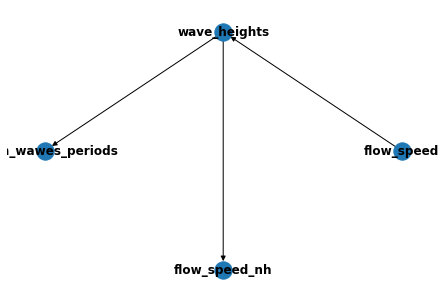

In [317]:
G_K2 = nx.DiGraph()
G_K2.add_edges_from(best_model.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')

In [318]:
transformed_data.shape

(1000, 4)

In [319]:
hc_BicScore = HillClimbSearch(transformed_data, scoring_method=BicScore(transformed_data))
best_model_BicScore = hc_BicScore.estimate()

  0%|                                                                           | 3/1000000 [00:00<13:56:47, 19.92it/s]


In [320]:
sample_Bic = sampling(best_model_BicScore, transformed_data, 1000)

Generating for node: mean_wawes_periods: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00, 114.65it/s]


In [321]:
sample_Bic

flow_speed  wave_heights  flow_speed_nh  mean_wawes_periods
0           6.0          11.0           13.0                 9.0
1          10.0           3.0            6.0                 6.0
2           6.0           5.0            9.0                 2.0
3           6.0           9.0           11.0                 9.0
4           4.0           6.0            7.0                 6.0
..          ...           ...            ...                 ...
995        11.0          13.0           13.0                14.0
996         5.0           8.0            9.0                 7.0
997         9.0          13.0           13.0                14.0
998         4.0           4.0            9.0                 5.0
999         4.0           4.0            4.0                 0.0

[1000 rows x 4 columns]

Generating for node: wave_heights: 100%|████████████████████████████████████████████████| 4/4 [00:00<00:00, 114.59it/s]


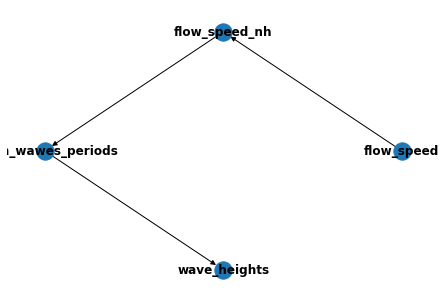

In [331]:
bn_new = BayesianModel()
bn_new.add_edge('flow_speed', 'flow_speed_nh')
bn_new.add_edge('flow_speed_nh', 'mean_wawes_periods')
bn_new.add_edge('mean_wawes_periods', 'wave_heights')
bn_new.fit(transformed_data)
G_K2 = nx.DiGraph()
G_K2.add_edges_from(bn_new.edges())
pos = nx.layout.circular_layout(G_K2)
nx.draw(G_K2, pos, with_labels=True,font_weight='bold')
sampler = BayesianModelSampling(bn_new)
manual_sample = sampler.forward_sample(size=1000, return_type='dataframe')

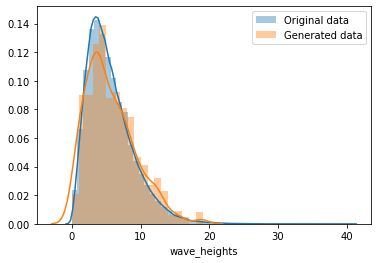

In [332]:
sns.distplot(df['wave_heights'], label='Original data')
sns.distplot(manual_sample['wave_heights'], label='Generated data')
plt.legend()

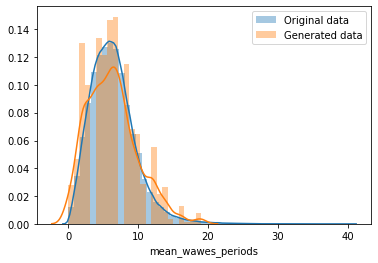

In [334]:
sns.distplot(df['mean_wawes_periods'], label='Original data')
sns.distplot(manual_sample['mean_wawes_periods'], label='Generated data')
plt.legend()

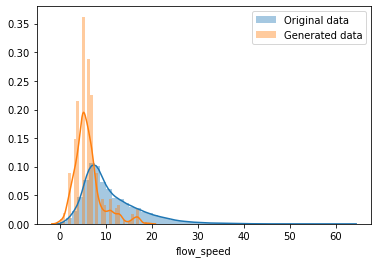

In [335]:
sns.distplot(df['flow_speed'], label='Original data')
sns.distplot(manual_sample['flow_speed'], label='Generated data')
plt.legend()

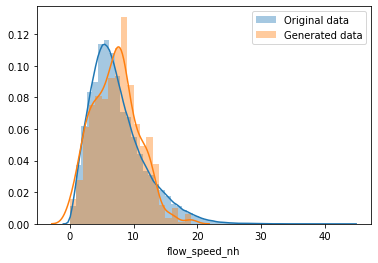

In [336]:
sns.distplot(df['flow_speed_nh'], label='Original data')
sns.distplot(manual_sample['flow_speed_nh'], label='Generated data')
plt.legend()

In [322]:
sample_Bic[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'wave_heights']] = est.inverse_transform(sample_Bic[['flow_speed', 'flow_speed_nh', 'mean_wawes_periods', 'wave_heights']].values)

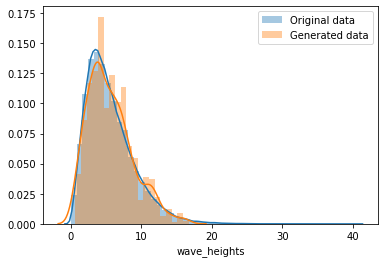

In [323]:
sns.distplot(df['wave_heights'], label='Original data')
sns.distplot(sample_Bic['wave_heights'], label='Generated data')
plt.legend()

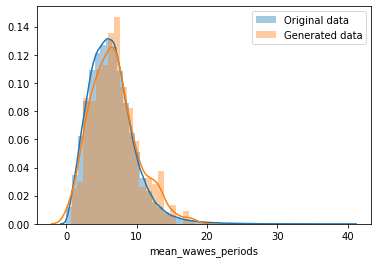

In [324]:
sns.distplot(df['mean_wawes_periods'], label='Original data')
sns.distplot(sample_Bic['mean_wawes_periods'], label='Generated data')
plt.legend()

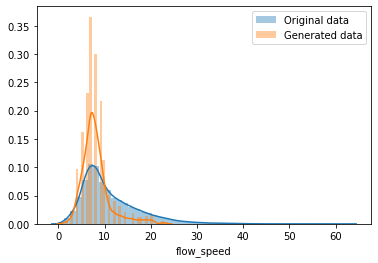

In [325]:
sns.distplot(df['flow_speed'], label='Original data')
sns.distplot(sample_Bic['flow_speed'], label='Generated data')
plt.legend()

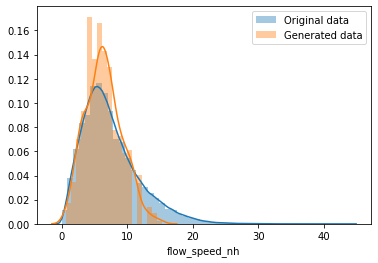

In [326]:
sns.distplot(df['flow_speed_nh'], label='Original data')
sns.distplot(sample_Bic['flow_speed_nh'], label='Generated data')
plt.legend()

In [337]:
from sklearn.metrics import mean_squared_error
from math import sqrt

def RMSE_params_restoration(bn: BayesianModel, data: pd.DataFrame):
    bn.fit(data)
    result = pd.DataFrame(columns=['Parameter', 'RMSE'])
    bn_infer = VariableElimination(bn)
    for j, param in enumerate(data.columns):
        accuracy = 0
        test_param = data[param]
        test_data = data.drop(columns=param)
        evidence = test_data.to_dict('records')
        predicted_param = []
        for element in evidence:
            prediction = bn_infer.map_query(variables=[param], evidence=element)
            predicted_param.append(prediction[param])
        accuracy = sqrt(mean_squared_error(test_param.values, predicted_param))
        result.loc[j,'Parameter'] = param
        result.loc[j, 'RMSE'] = accuracy
    return result

In [338]:
print('1')
rmse = RMSE_params_restoration(BayesianModel(bn_new.edges()), transformed_data)
print(rmse)

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]

1


Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimina

Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]
0it [00:00, ?it/s]
Finding Elimination Order: : : 0it

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding El

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding El

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]
Finding Elimination Order: : : 0it [00:00, ?it/s]

0it [00:00

0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]


0it [00:00, ?it/s]


0it [00:00, ?it/s]

Finding Elimination Order: : 

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

            Parameter     RMSE
0          flow_speed  3.03348
1       flow_speed_nh   3.0929
2  mean_wawes_periods  1.78326
3        wave_heights  1.94628


In [339]:
print('2')
rmse = RMSE_params_restoration(BayesianModel(best_model_BicScore.edges()), transformed_data)
print(rmse)

2





0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Eliminat

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:0

0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]


Finding Elimination Order: : : 0it [00:00, ?it/s]



0it [00:00, ?it/s]



0it [00:00, ?it/s]

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00

Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding Elimination Order: : : 0it [00:00, ?it/s]




0it [00:00, ?it/s]




0it [00:00, ?it/s]



Finding El

0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it 

Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it

0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it 

0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]





0it [00:00, ?it/s]




Finding Elimination Order: : : 0it [00:00, ?it/s]





0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elim

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Findin

Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]






0it [00:00, ?it/s]






0it [00:00, ?it/s]





Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Fin

0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0i

Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: :

0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Finding Elimination Order: : : 0it [00:00, ?it/s]







0it [00:00, ?it/s]







0it [00:00, ?it/s]






Fin

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







F

0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0

0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







F

0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0

0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0

Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]








0it [00:00, ?it/s]







Finding Elimination Order: : : 0it [00:00, ?it/s]








0it [00:00, ?it/s]

            Parameter      RMSE
0          flow_speed   3.10097
1       flow_speed_nh   2.25233
2  mean_wawes_periods   2.06228
3        wave_heights  0.980816
